In [497]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy.stats import binom, nbinom
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm

In [498]:
import tensorflow as tf

In [499]:
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

# Prior and Model

In [500]:
def convert_params(mu, phi):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports
    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = phi
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [537]:
def prior_SIR(batch_size):
    
    beta0 = np.random.uniform(1.0, 3.0, size=batch_size)
    mu = np.random.uniform(1/14, 1/3, size=batch_size)
    gamma = np.random.uniform(1/14, 1/3, size=batch_size)
    eps = np.random.uniform(0.1, 1, size=batch_size)
    theta = np.random.uniform(0.9, 10, size=batch_size)
    sigma = np.random.exponential(5, size=batch_size)
    return np.c_[beta0, mu, gamma, eps, theta, sigma]


def seasonal_SIR(params, N, T, I0=1, ret_obs=True):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters and round I0
    beta0, mu, gamma, eps, theta, sigma = params
    beta = calc_beta(beta0, eps, theta, T)
    
    # Initial conditions
    S, I, R = [N-I0], [I0], [0]
    I_news = [I0]
    
    # Simulate T-1 tiemsteps
    for t in range(T-1):
        
        # Calculate new cases
        I_new = np.clip(beta[t]*(I[-1]*S[-1]/N), 0, N)
        S_t = S[-1] - I_new + mu*N - mu*S[-1]        
        I_t = I[-1] + I_new - (gamma + mu)*I[-1]
        R_t = R[-1] + gamma*I[-1] - mu*R[-1]
        
        S_t = np.clip(S_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        
        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        I_news.append(I_new)
    if ret_obs:
        new = np.array(I_news)
        new = np.clip(np.random.normal(new, scale=np.sqrt(new)*sigma), 0, N)
        return new
    return np.stack([S, I, R]).T

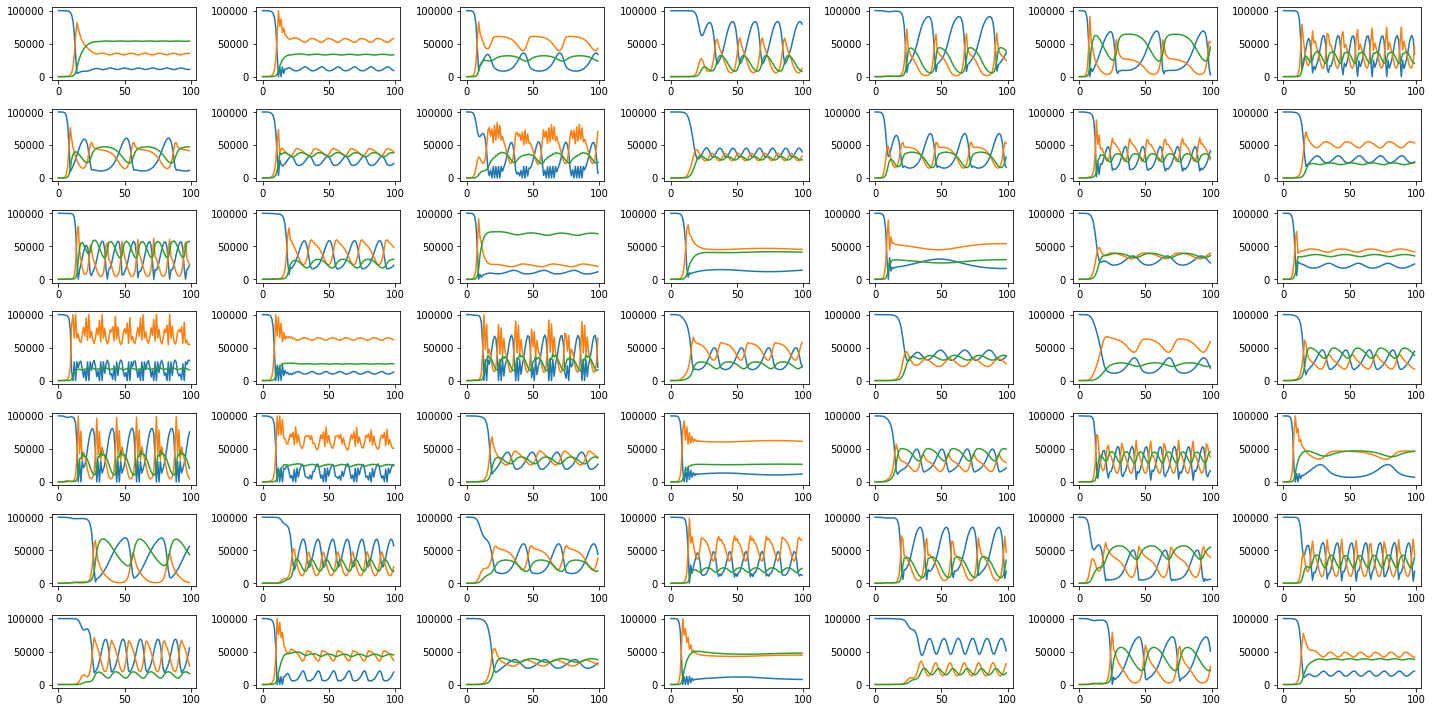

In [507]:
f, axarr = plt.subplots(7, 7, figsize=(20, 10))

for ax in axarr.flat:
    
    p = prior_SIR(1)[0]
    x = seasonal_SIR(p, 100000, 100, ret_obs=False)
    ax.plot(x)
f.tight_layout()

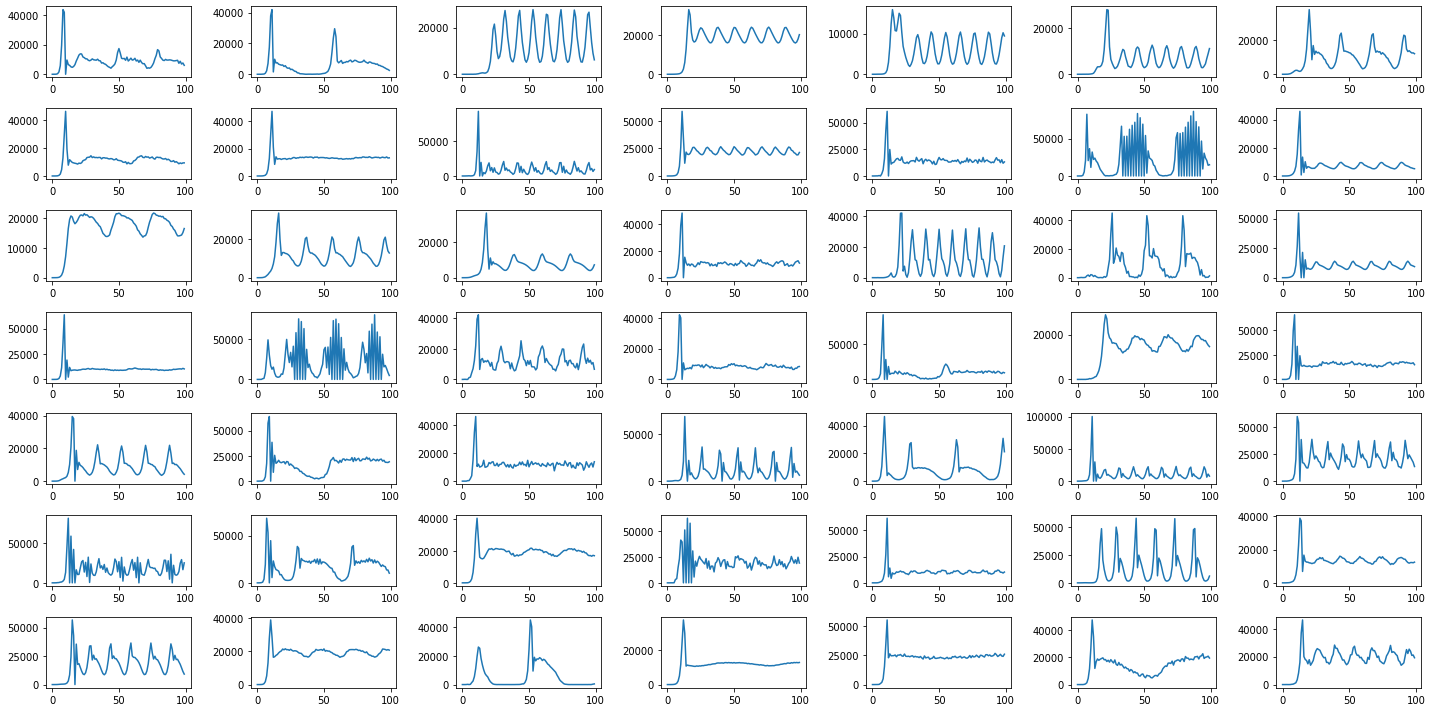

In [516]:
f, axarr = plt.subplots(7, 7, figsize=(20, 10))

for ax in axarr.flat:
    
    p = prior_SIR(1)[0]
    x = seasonal_SIR(p, 100000, 100, ret_obs=True)
    ax.plot(x)
f.tight_layout()

In [541]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(2, 3, figsize=figsize)
    axarr = axarr.flat

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], ax=axarr[j], color='#a34f4f',edgecolor="k", linewidth=1, alpha=1., bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')
    
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}_Entire.png".format(filename), dpi=300)

# Data Generator for Neural Net

In [525]:
def data_generator(batch_size, T=None, N=None, I0=None, T_min=10, T_max=90, 
                   N_min=10000, N_max=70000000, 
                   to_tensor=True, seed=None):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    simulator  : callable -- the data simulator
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Variable-size t
    if T is None:
        T = np.random.randint(T_min, T_max+1)

    # Sample from prior, params is a np.array of shape (batch_size, theta_dim)
    params = prior_SIR(batch_size)
 
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    for i in range(batch_size):
        # Simulate SECIR
        x_i = seasonal_SIR(params[i, :], N, T, I0)
        x.append(x_i)
    x = np.log1p(np.array(x)[:, :, np.newaxis])

    # Convert to tensor, if specified 
    if to_tensor:
        params = tf.convert_to_tensor(params, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': params,  'x': x}

# Training Hyperparameters

In [526]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


n_summary = 64
n_inv_blocks = 4
param_names = [r'$\beta_0$', r'$\mu$', r'$\gamma$', r'$\eps', r'$\theta$', r'$\sigma$']
theta_dim = len(param_names)
n_test = 300


# Training and optimizer hyperparameters
ckpt_file = "SIR_Seasonal"
batch_size = 64
epochs = 10
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.


starter_learning_rate = 0.0009
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [527]:
T = 100
N = 100000
I0 = 1
data_gen = partial(data_generator, T=T, N=N, I0=I0)

In [528]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            tf.keras.layers.Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(1, 8)
        ]
        self.dim_red = tf.keras.layers.Conv1D(n_filters, 1, 1, 
                                              activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary):
        super(SummaryNet, self).__init__()
        
        self.conv = MultiConvLayer(n_filters=n_summary)
        self.lstm = tf.keras.layers.LSTM(n_summary)

    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""

        out = self.conv(x)
        out = self.lstm(out)
        return out

In [529]:
summary_net = SummaryNet(n_summary)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

In [530]:
%%time
test_data = data_gen(n_test)

Wall time: 2.05 s


In [532]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}/'.format(ckpt_file), max_to_keep=10)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [27]:
# plot_true_est_scatter(model, test_data['x'], test_data['theta'], 
#                       n_samples_posterior, param_names, figsize=(12, 3))

In [28]:
def plot_posteriors_germany(n_samples, data):
    samples = model.sample(data, n_samples, to_numpy=True)
    samples = samples[np.sum(samples < 0, axis=1) == 0]
    f, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        sns.distplot(samples[:, i], kde=False, bins=50, ax=ax[i], 
                     hist_kws={'color': 'orange', 'alpha': 0.8, 'edgecolor': 'white', 'linewidth': 1.0})
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax[i].set_title(param_names[i])
    f.tight_layout()
    plt.show()
    


In [533]:
# starter_learning_rate = 0.0001
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#     starter_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.99,
#     staircase=True
# )

In [534]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value,
                              clip_method='global_norm')
        
        # Manage checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 2h 7min 10s


In [535]:
test_data_sbc = data_gen(5000)
theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
                                for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)

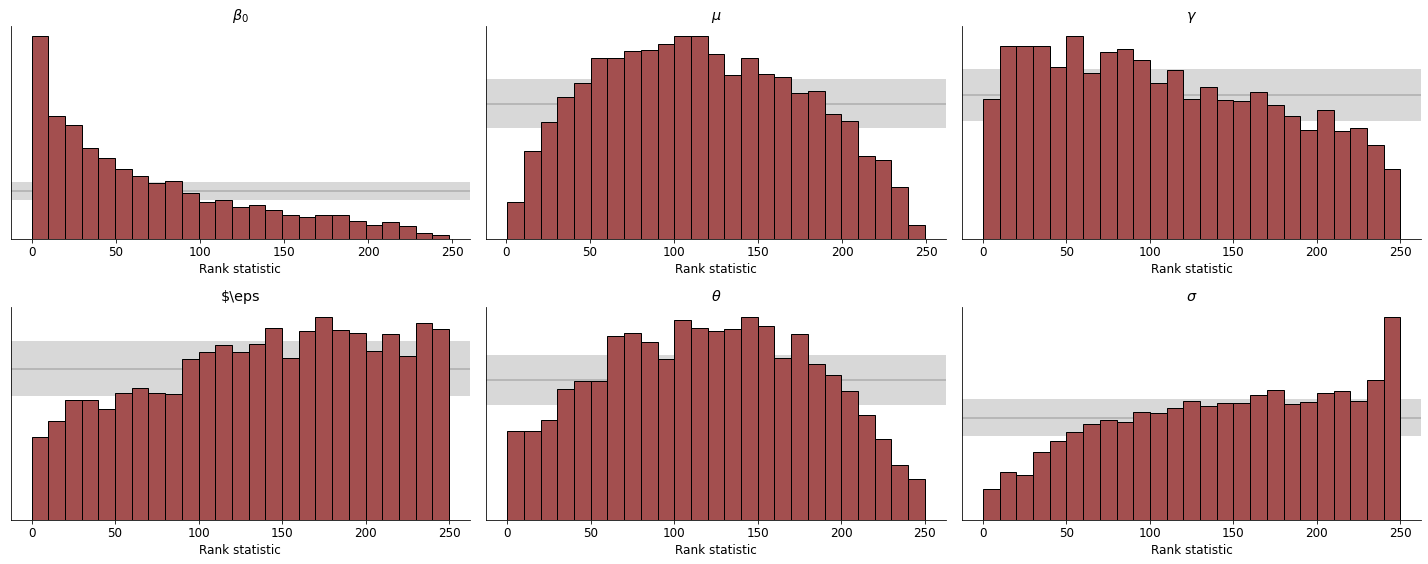

In [542]:
plot_sbc(theta_samples, 
         test_data_sbc['theta'], 
         param_names, 
         bins=25,
         figsize=(20, 8), 
         filename=None)

In [553]:
def plot_median_predictions(n_samples, data, logscale=True):
    
    samples = model.sample(data, n_samples, to_numpy=True)
    data_1d = np.exp(data[0, :, 0].numpy()) - 1
    samples = samples[np.sum(samples < 0, axis=1) == 0]
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    sims = []
    for i in range(samples.shape[0]):   
        sim_cases = seasonal_SIR(samples[i], N, T)
        sims.append(sim_cases)
    sims = np.array(sims)
    qs = np.quantile(sims, q=[0.025, 0.975], axis=0)
    ax.plot(np.median(sims, axis=0), label='Predicted cases', color='orange')
    ax.plot(data_1d, marker='o', label='Reported cases', color='blue')
    ax.fill_between(range(T), qs[0], qs[1], color='orange', alpha=0.2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days')
    ax.set_ylabel('Daily new reported cases')
    if logscale:
        ax.set_yscale('log')
    ax.legend()
    plt.show()

In [554]:
# test_data['x'][0:1]

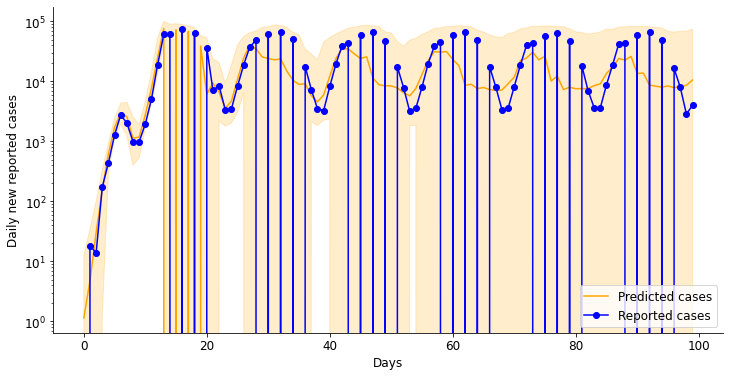

In [558]:
plot_median_predictions(1000, test_data['x'][3:4])

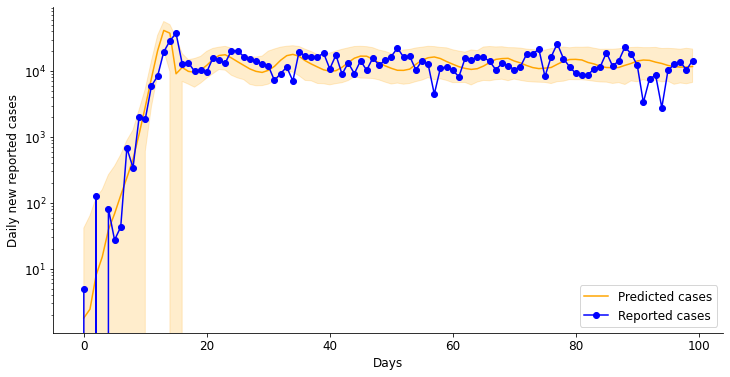

In [559]:
plot_median_predictions(1000, test_data['x'][4:5])

In [551]:
np.exp(x) - 1

30.0